In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import plotly.express as px

from copy import deepcopy

from kmcluster.core.utils import fetch_pt7_data
from kmcluster.core.data import sparse_to_mat
from kmcluster.core.data import energy_to_rates
from kmcluster.core.intialize import random_init, boltz
from kmcluster.core.viz import graph_trajectories_static
from kmcluster.core.cluster import (
    plot_coms_cdlib,
    plot_affinity_at_temp,
)
from kmcluster.core.data import sparse_to_mat, test_dataset_1, test_dataset_2

#import expm
from scipy.linalg import expm
# supress warnings
import warnings

warnings.filterwarnings("ignore")

/home/santiagovargas/anaconda3/envs/allegro/lib/python3.9/site-packages/brisk/funcs.py:99: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dot(x, y):
/home/santiagovargas/anaconda3/envs/allegro/lib/python3.9/site-packages/brisk/funcs.py:174: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def interp(x, xp, fp):
/home/santiagovargas/anaconda3/envs/allegro/lib/pyt

In [18]:
# get data
T = 100 # temperature
k_b = 8.617 * 10 ** (-5)
huan_all, huan_rel = huan_bars = fetch_pt7_data()
Pt_H1_all, H1_E = test_dataset_2()

energies = H1_E
energies_rel = Pt_H1_all
energies_mat = sparse_to_mat(energies_rel)

# generate boltzman distribution
boltz_dist = boltz(size=10000, energies=energies, kb_T=k_b*T)
rand_dist = random_init(size=10000, n_states=len(energies))
init_dist = boltz_dist.get_init_populations()
init_dist_rand = rand_dist.get_init_populations()
init_dist_rand_prop = init_dist_rand / np.sum(init_dist_rand)
init_dist_prop = init_dist / np.sum(init_dist)


initialization populations
{0: 400, 1: 395, 2: 364, 3: 406, 4: 401, 5: 357, 6: 395, 7: 366, 8: 394, 9: 394, 10: 417, 11: 386, 12: 359, 13: 387, 14: 361, 15: 377, 16: 400, 17: 410, 18: 434, 19: 350, 20: 329, 21: 396, 22: 401, 23: 371, 24: 380, 25: 370}


In [19]:
def energy_to_jacobian(e_mat):
    rate_mat = energy_to_rates(e_mat, T, scale=1)
    # Note: This is required for the continuous markov approximations
    rate_mat_diag_neg = rate_mat - np.diag(np.sum(rate_mat, axis=0))
    return rate_mat_diag_neg

# These are just different propagation equations. Some work better than others. 
def taylor_expand_prop(eig_mat, t, order = 3, filter = True):
    # initialize matrix
    if filter:
        eig_mat[ np.abs(eig_mat) < 1e-9] = 0
    taylor_mat = np.zeros_like(eig_mat)
    # loop over order
    for i in range(order):
        # add to matrix
        taylor_mat += np.linalg.matrix_power(t * eig_mat, i) / np.math.factorial(i)
    return taylor_mat


def propagate(a_0, time, eig_mat, eigvecs, inv_eigvecs, order = 3, filter = False):
    """
    a_0: initial distribution
    time: time to propagate
    eigvecs: eigenvectors of rate matrix
    inv_eigvecs: inverse of eigenvectors of rate matrix
    order: order of taylor expansion
    """
    # initialize matrix
    prop_mat = np.zeros_like(eigvecs)
    # loop over order
    taylor_mat = taylor_expand_prop(eig_mat, time, order, filter=filter)
    # multiply by eigenvectors
    prop_mat = np.matmul(eigvecs, np.matmul(taylor_mat, inv_eigvecs))
    # multiply by initial distribution
    prop_mat = np.matmul(prop_mat, a_0)
    return prop_mat


def propagate_alt(a_0, time, eig_mat, eigvecs, inv_eigvecs, order = 3):
    """
    a_0: initial distribution
    time: time to propagate
    eigvecs: eigenvectors of rate matrix
    inv_eigvecs: inverse of eigenvectors of rate matrix
    order: order of taylor expansion
    """
    ret_mat = np.zeros_like(a_0, dtype=np.complex128)
    # loop over all eigenvectors
    for i in range(len(eigvecs)):
        # get eigenvalue
        eig_val = eig_mat[i, i]
        # get eigenvector
        eig_vec = eigvecs[:, i]
        # get inverse eigenvector
        inv_eig_vec = inv_eigvecs[i, :]
        # get taylor expansion
        #print(inv_eig_vec * a_0 * np.exp(-1 * eig_val * time) * eig_vec)
        ret_mat += inv_eig_vec * a_0 * np.exp(-1 * eig_val * time) * eig_vec
    
    return ret_mat


def propagate_base(a_0, time, rates):
    temp_rates = deepcopy(rates)
    exp_term = expm(temp_rates * time)
    # normalize
    #exp_term = exp_term #/ np.sum(exp_term,  axis=0)
    return np.dot(exp_term, a_0)




In [14]:
"""
# get eigenvalues and eigenvectors of transition_mat 
transition_mat = rate_mat / np.sum(rate_mat, axis=0)[:, np.newaxis]
eigvals, eigvecs = np.linalg.eig(transition_mat)
# find stationary distribution
pi = eigvecs[:, np.argmax(eigvals.real)]
# normalize stationary distribution
pi = pi / np.sum(pi)
# filter out states with low probability
pi[pi < 1e-3] = 0
"""

'\n# get eigenvalues and eigenvectors of transition_mat \ntransition_mat = rate_mat / np.sum(rate_mat, axis=0)[:, np.newaxis]\neigvals, eigvecs = np.linalg.eig(transition_mat)\n# find stationary distribution\npi = eigvecs[:, np.argmax(eigvals.real)]\n# normalize stationary distribution\npi = pi / np.sum(pi)\n# filter out states with low probability\npi[pi < 1e-3] = 0\n'

In [15]:
"""
# get eigenvalues and eigenvectors of rate matrix
eigvals, eigvecs = np.linalg.eig(rate_mat_diag_neg)
# sort eigenvalues and eigenvectors
idx = eigvals.argsort()[::-1]
# make any eigenvalues close to zero zero
#eigvals[eigvals] = 0
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

eig_mat = np.diag(eigvals)
eig_vec_mat = eigvecs
eig_vec_mat_inv = np.linalg.inv(eig_vec_mat)
# if this give you an singular matrix error use np.linalg.pinv instead
"""

'\n# get eigenvalues and eigenvectors of rate matrix\neigvals, eigvecs = np.linalg.eig(rate_mat_diag_neg)\n# sort eigenvalues and eigenvectors\nidx = eigvals.argsort()[::-1]\n# make any eigenvalues close to zero zero\n#eigvals[eigvals] = 0\neigvals = eigvals[idx]\neigvecs = eigvecs[:, idx]\n\neig_mat = np.diag(eigvals)\neig_vec_mat = eigvecs\neig_vec_mat_inv = np.linalg.inv(eig_vec_mat)\n# if this give you an singular matrix error use np.linalg.pinv instead\n'

In [16]:
rate_mat_diag_neg = energy_to_jacobian(energies_mat)

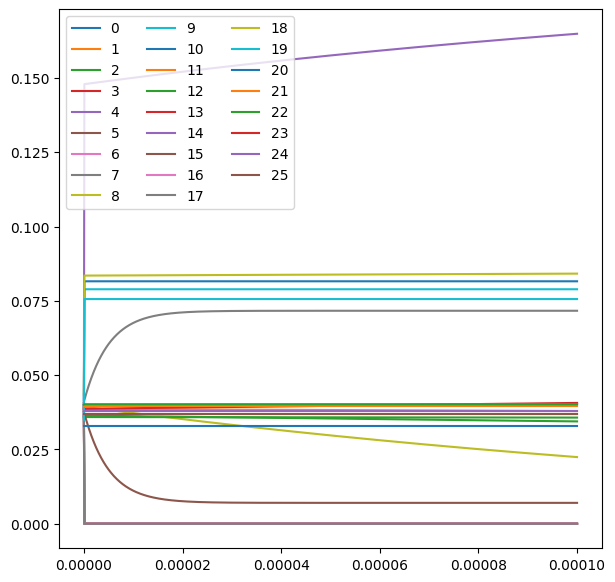

In [22]:

plt.figure(figsize=(7,7))

# two ways to denote time
max_time=0.0001
samples = [0, 10e-12, 10e-11, 10e-10, 10e-9, 10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1]
samples = np.linspace(0, max_time, 1000)

prop_dict = {}
dict_state_major = {}
for sample in samples:
    dist_at_time = propagate_base(
        init_dist_rand_prop, 
        sample, 
        rate_mat_diag_neg
    )
    prop_dict[sample] = dist_at_time


# convert to df 

# plot the results

for i in range(len(prop_dict[0])):
    prop_time = [prop_dict[sample][i] for sample in samples]
    #print(prop_time[:2])
    plt.plot(samples, prop_time)
    dict_state_major[i] = prop_time
    #print(i, prop_time[0])

df_res = pd.DataFrame.from_dict(dict_state_major)
label_tuple = tuple([i for i in range(prop_dict[0].shape[0])])

#plt.xscale("log")
plt.legend(label_tuple, loc="best", ncols=3)

In [23]:
prop_time = [prop_dict[sample][14] for sample in samples]
print(prop_time)

[0.0361, 0.1479086460622645, 0.14793084095893055, 0.14795302318931686, 0.14797519291230865, 0.14799735013443668, 0.14801949486342184, 0.1480416271057388, 0.14806374686918797, 0.1480858541600592, 0.14810794898486673, 0.14813003135277691, 0.1481521012680559, 0.1481741587405988, 0.1481962037737962, 0.14821823637894968, 0.14824025655973655, 0.1482622643241558, 0.14828425968042921, 0.14830624263403808, 0.14832821319083514, 0.14835017136273024, 0.1483721171511658, 0.1483940505642243, 0.14841597161176215, 0.1484378802998575, 0.14845977663418508, 0.14848166061782564, 0.14850353226691496, 0.14852539158242298, 0.1485472385742225, 0.14856907324550125, 0.14859089560505054, 0.1486127056601143, 0.14863450341693302, 0.14865628888443053, 0.1486780620678163, 0.14869982297357123, 0.1487215716100868, 0.1487433079812668, 0.1487650320968308, 0.1487867439679146, 0.14880844359320083, 0.14883013098455505, 0.1488518061433371, 0.14887346908382898, 0.14889511980461337, 0.14891675832648807, 0.14893838463793338, 0

In [24]:
count_df = df_res
n_show = len(count_df)

x_axis = samples
count_df.index = x_axis
count_df.columns = np.arange(0, count_df.shape[1])
sum_count = count_df.sum(axis=0)
# get top n states
keys_top_n = sum_count.nlargest(n_show).index.to_list()
# sort keys
df_show = count_df[keys_top_n]


fig = px.area(
    df_show, 
    title="test", 
    x=x_axis, 
    y=df_show.keys()
    )

# set xlim
fig.update_xaxes(range=[0, max_time])
# set ylim
fig.update_yaxes(range=[0, 1])
# show legend
fig.update_layout(showlegend=True)

fig.show()


In [25]:

fig = px.line(df_show, title="test", x=x_axis, y=df_show.keys())

# set xlim
fig.update_xaxes(range=[0, max_time])
# set ylim
fig.update_yaxes(range=[0, 1])
# show legend
fig.update_layout(showlegend=True)

fig.show()
